# Shreyank Shetty (12279686)
## FINM 33150 1 Regression Analysis and Quantitative Trading Strategies
### Homework: Futures Spread Dynamics


### Fetching Data from Quandl

In [187]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import os
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot_2samples

import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [90]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities):
#     print("Fetching from Quandl")
#     print(my_securities)
    qdata = quandl.get(list(my_securities), returns="pandas",
                      api_key='Uqzcx--xVuNuaLvU48UU',
                      start_date='2019-12-03', end_date='2021-08-31')
    return qdata
    print("fetch_quandl has now been newly defined")

def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data


In [83]:
def get_quaterly_price(option):
    data = pd.DataFrame()
    last= pd.Timestamp('2019-12-03')
    for y in ['2020','2021']:
        for q in ['H','M','U','Z']:
            if q+y != 'Z2021':
                current = clean_quandl_columns(fetch_quandl((option+'_'+q+y+'_IVM',)))[['Future','DtT']].copy()
                future= current[current['DtT']>30]['Future'][last:]
                data= data.append(pd.DataFrame(future))
                last= future.index[-1]+pd.Timedelta(days=1)
    return data 
                

### Extracting second month quaterly future price for the below pairs of options 
6. CBT FV FV CBT US US - Spread 1 (s1) (30-Year US T-Bonds vs 5-Year US T-Notes)
8. CBT TU TU CBT US US - Spread 2 (s2) (30-Year US T-Bonds vs 2-Year US T-Notes)

In [94]:
cbt_fv = get_quaterly_price('OWF/CBT_FV_FV')
cbt_us = get_quaterly_price('OWF/CBT_US_US')
cbt_tu= get_quaterly_price('OWF/CBT_TU_TU')
s1 = cbt_us-cbt_fv
s2 = cbt_us-cbt_tu
s2.head()

,Future
Date,
2019-12-03,52.179688
2019-12-04,50.918750
2019-12-05,50.543750
2019-12-06,49.906250
2019-12-09,50.262500


### Testing data 

In [97]:
s2.loc['2021-02-18']

Future    54.023438
Name: 2021-02-18 00:00:00, dtype: float64

In [95]:
s1.loc['2021-02-18']

Future    39.023438
Name: 2021-02-18 00:00:00, dtype: float64

In [96]:
s1.loc['2021-02-19']

Future    36.59375
Name: 2021-02-19 00:00:00, dtype: float64

## Analysis 

In [146]:
spread= pd.concat([s1, s2], axis=1)
spread.columns=['CBT_US-FV','CBT_US-TU']
futures= pd.concat([cbt_fv,cbt_us,cbt_tu],axis=1)
futures.columns=['CBT_FV','CBT_US','CBT_TU']
spread.head()

,CBT_US-FV,CBT_US-TU
Date,,
2019-12-03,40.726562,52.179688
2019-12-04,39.726562,50.918750
2019-12-05,39.421875,50.543750
2019-12-06,38.960938,49.906250
2019-12-09,39.289062,50.262500


#### Plotting the spreads

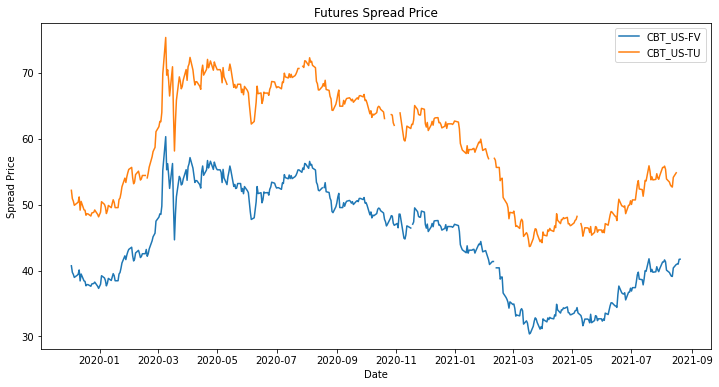

In [147]:
plt.figure(1, figsize=(12,6))
plt.plot(spread)
plt.title('Futures Spread Price')
plt.xlabel('Date')
plt.ylabel('Spread Price')
plt.legend(spread.columns)

From the graph we can see that the two spreads have similar trends. The Spread s1(CBT_US_US-FV_FV- 5year) has a lower level than spread s2(CBT_US_US-TU_TU- 2year). 

Which is inline with expectations as the spread between the 30 year US T-bonds and 5 years US T-notes  and 30 year US T-bonds and 2 years US T-notes would move similarly. 


Text(0.5, 1.0, 'Distribution of US 30 T-Bond Vs 5 year T-Bill')

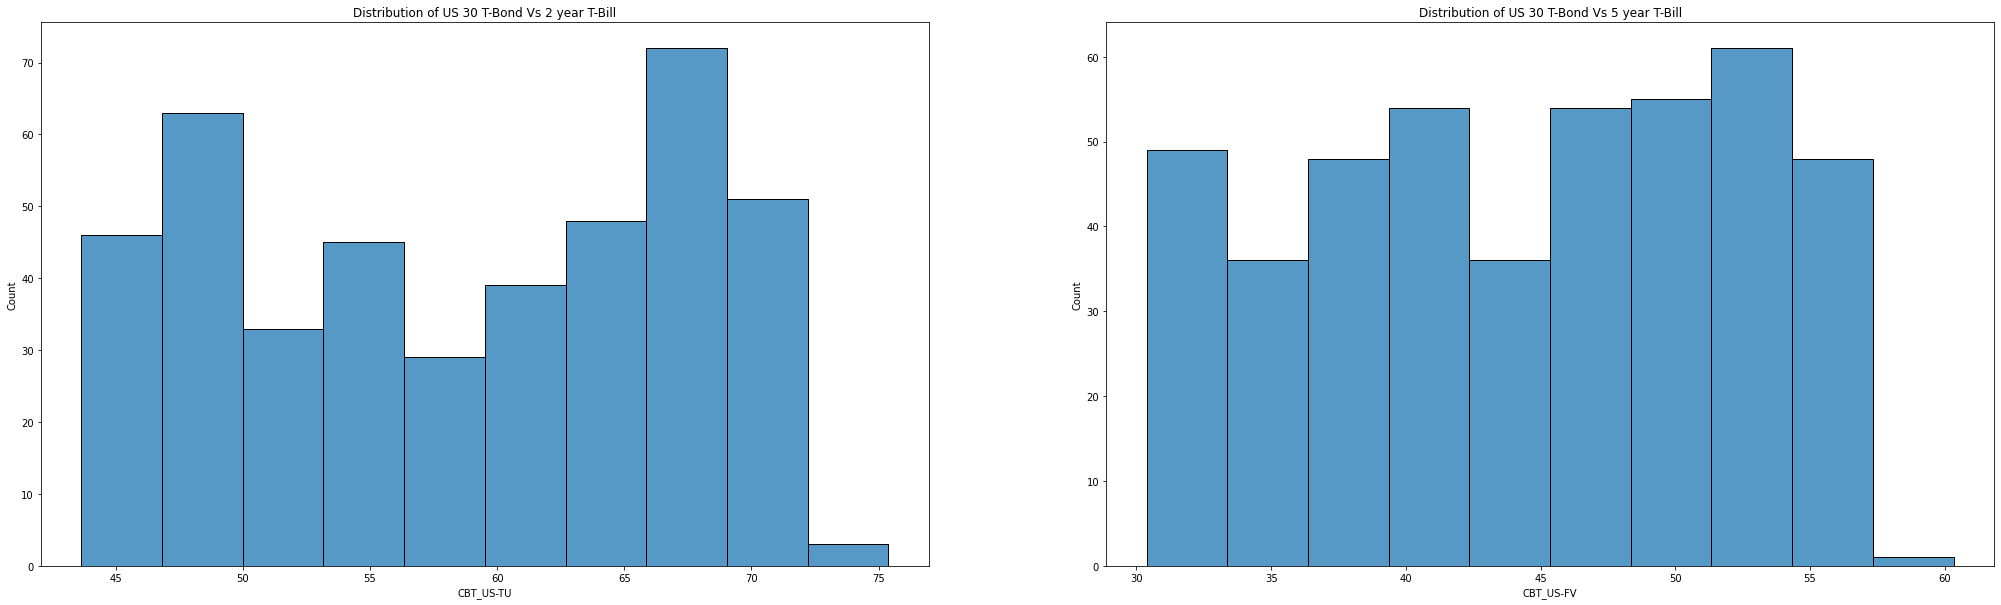

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(35,10))
sns.histplot(spread["CBT_US-TU"],ax=ax[0])
ax[0].set_title("Distribution of US 30 T-Bond Vs 2 year T-Bill")
sns.histplot(spread["CBT_US-FV"],ax=ax[1])
ax[1].set_title("Distribution of US 30 T-Bond Vs 5 year T-Bill")

##### Plotting spread difference

In [148]:
spread['spread_diff'] = spread['CBT_US-FV'] - spread['CBT_US-TU']
spread.head()

,CBT_US-FV,CBT_US-TU,spread_diff
Date,,,
2019-12-03,40.726562,52.179688,-11.453125
2019-12-04,39.726562,50.918750,-11.192188
2019-12-05,39.421875,50.543750,-11.121875
2019-12-06,38.960938,49.906250,-10.945312
2019-12-09,39.289062,50.262500,-10.973438


Text(0, 0.5, 'Spread Difference')

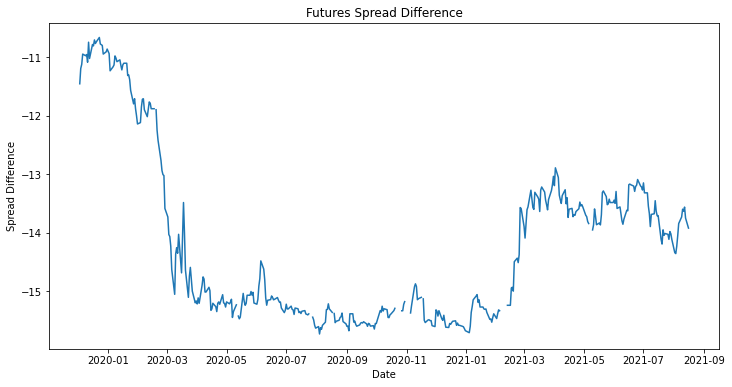

In [149]:
plt.figure(2, figsize=(12,6))
plt.plot(spread['spread_diff'])
plt.title('Futures Spread Difference')
plt.xlabel('Date')
plt.ylabel('Spread Difference')

We find that the spread difference is very small (-10,-16). Also the spread difference is low in the begining and then begins to diverge. Towards march 2021, we see the spread differnce converge again.

##### Box plot of spread

<AxesSubplot:>

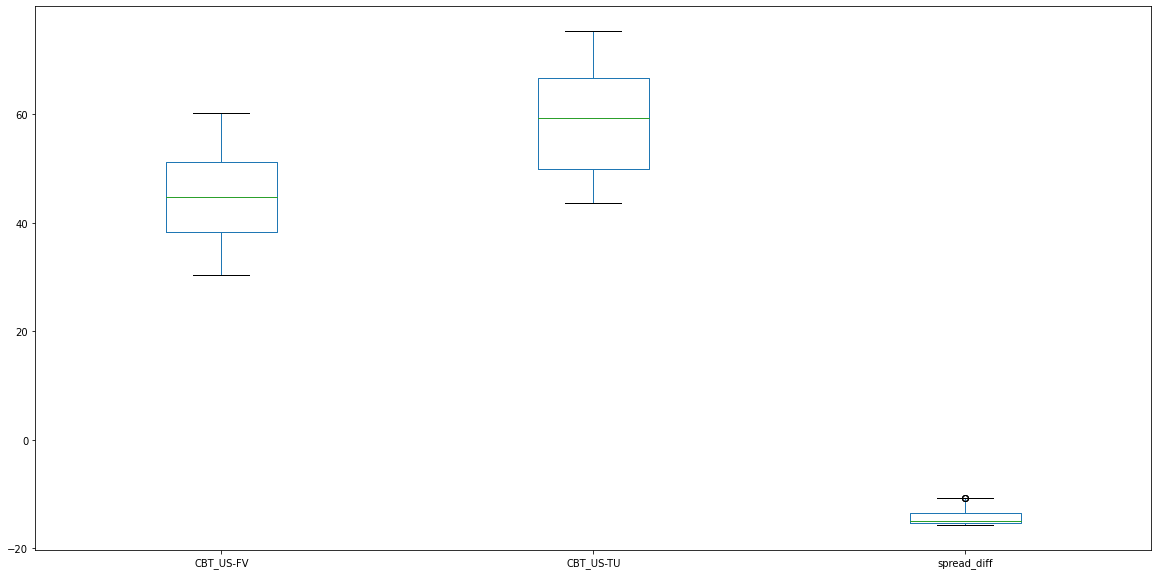

In [208]:

spread.plot.box()

##### Plotting Spread returns 

In [129]:
spread_ret = spread.pct_change().dropna()
spread_ret.head()

,CBT_US_US-FV_FV,CBT_US_US-TU_TU,spread_diff
Date,,,
2019-12-04,-0.024554,-0.024165,-0.022783
2019-12-05,-0.007670,-0.007365,-0.006282
2019-12-06,-0.011692,-0.012613,-0.015875
2019-12-09,0.008422,0.007138,0.002570
2019-12-10,0.004176,0.002860,-0.001851


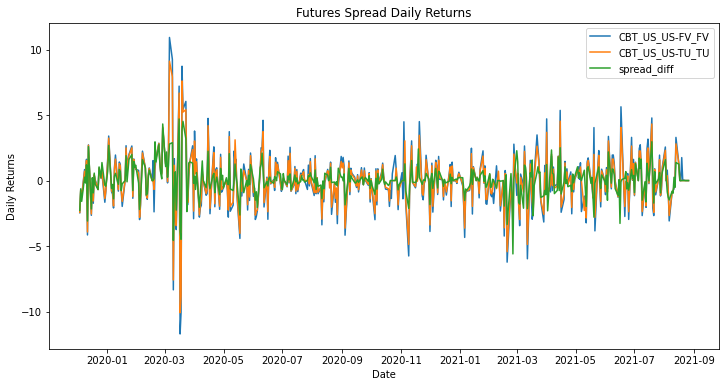

In [130]:
plt.figure(1, figsize=(12,6))
plt.plot(spread_ret*100)
plt.title('Futures Spread Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend(spread_ret.columns)

##### Plotting Log Returns

Text(0.5, 1.0, 'Distribution of log returns')

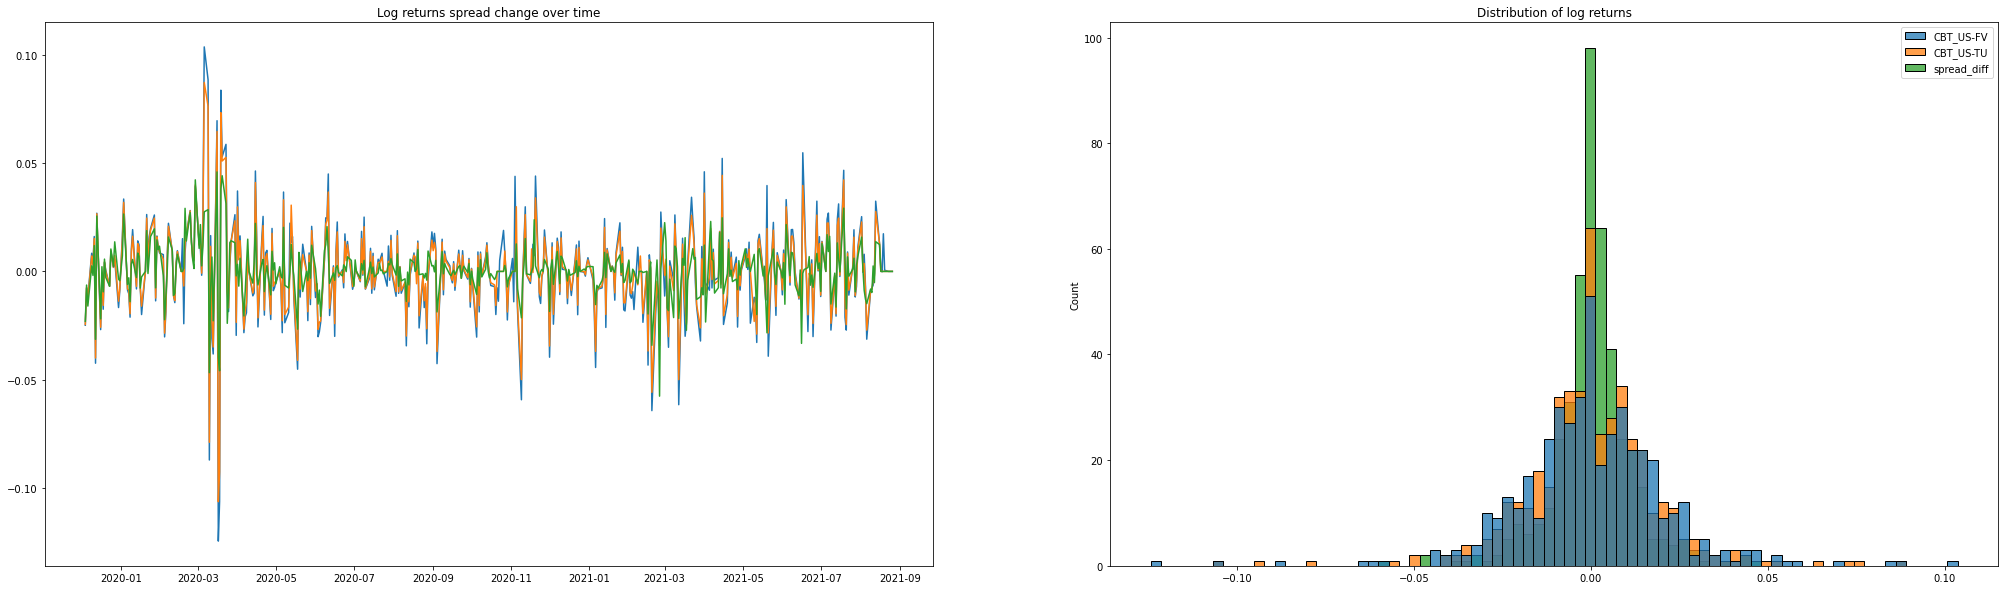

In [160]:
logreturns = np.log(1+ spread.pct_change())
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(35,10))
ax[0].plot(logreturns)
ax[0].set_title("Log returns spread change over time")

sns.histplot(logreturns,ax=ax[1])
ax[1].set_title("Distribution of log returns")


## Spread Statistics 

In [132]:
spread.describe()

,CBT_US_US-FV_FV,CBT_US_US-TU_TU,spread_diff
count,442.000000,429.000000,425.000000
mean,44.443987,58.667697,-14.223092
std,7.689053,8.708057,1.397659
min,30.375000,43.646875,-15.732812
25%,38.330078,49.918750,-15.340625
50%,44.851562,59.396875,-14.914062
75%,51.193359,66.734375,-13.498437
max,60.328125,75.382812,-10.660938


### Moving Average analysis ( for spread 1(CBT_US-FV))

In [162]:
rolling_avg=pd.DataFrame()
rolling_avg['10_mavg'] = spread['CBT_US-FV'].rolling(window=10, min_periods=1, center=False).mean()
rolling_avg['20_mavg'] = spread['CBT_US-FV'].rolling(window=20, min_periods=1, center=False).mean()
rolling_avg['50_mavg'] = spread['CBT_US-FV'].rolling(window=50, min_periods=1, center=False).mean()
rolling_avg['100_mavg'] = spread['CBT_US-FV'].rolling(window=100, min_periods=1, center=False).mean()


In [163]:
rolling_diff=pd.DataFrame()
rolling_diff['10_diff']=spread['CBT_US-FV']- rolling_avg['10_mavg']
rolling_diff['20_diff']=spread['CBT_US-FV']- rolling_avg['20_mavg']
rolling_diff['50_diff']=spread['CBT_US-FV']- rolling_avg['50_mavg']
rolling_diff['100_diff']=spread['CBT_US-FV']- rolling_avg['100_mavg']

Text(0.5, 1.0, 'Spread - Rolling Avg of 100days')

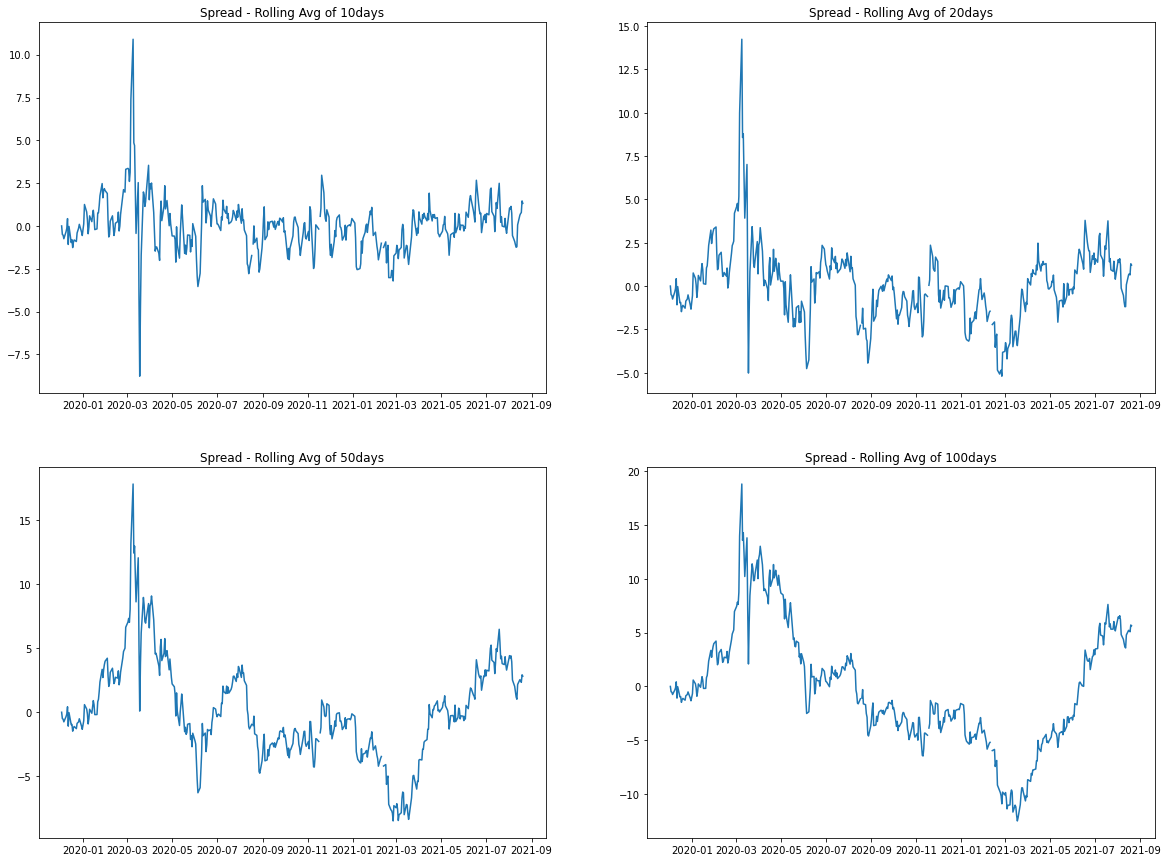

In [164]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
ax[0, 0].plot(rolling_diff["10_diff"])
ax[0, 1].plot(rolling_diff["20_diff"])
ax[1, 0].plot(rolling_diff["50_diff"])
ax[1, 1].plot(rolling_diff["100_diff"])
ax[0, 0].set_title("Spread - Rolling Avg of 10days")
ax[0, 1].set_title("Spread - Rolling Avg of 20days")
ax[1, 0].set_title("Spread - Rolling Avg of 50days")
ax[1, 1].set_title("Spread - Rolling Avg of 100days")

## Tail Statistics 

In [176]:
tail_stats=pd.DataFrame()
for avg in rolling_diff.columns:
    tail_stats.loc["Kurtosis",avg]=rolling_diff[avg].kurtosis()
    tail_stats.loc["Skewness",avg]=rolling_diff[avg].skew()
    tail_stats.loc["Median",avg]=rolling_diff[avg].median()
    tail_stats.loc["5th Quantile",avg]=rolling_diff[avg].quantile(0.05)
    tail_stats.loc["25th Quantile",avg]=rolling_diff[avg].quantile(0.25)
    tail_stats.loc["50th Quantile",avg]=rolling_diff[avg].quantile(0.5)
    tail_stats.loc["75th Quantile",avg]=rolling_diff[avg].quantile(0.75)
tail_stats

,10_diff,20_diff,50_diff,100_diff
Kurtosis,10.147410,6.668174,1.604203,0.018255
Skewness,0.664785,1.138851,0.570822,0.337260
Median,0.065234,0.032761,-0.311108,-0.928991
5th Quantile,-2.247812,-3.164473,-6.211637,-9.794559
25th Quantile,-0.735395,-1.131152,-2.163934,-3.772431
50th Quantile,0.065234,0.032761,-0.311108,-0.928991
75th Quantile,0.725195,1.174219,2.501289,3.158693


<Figure size 1440x720 with 0 Axes>

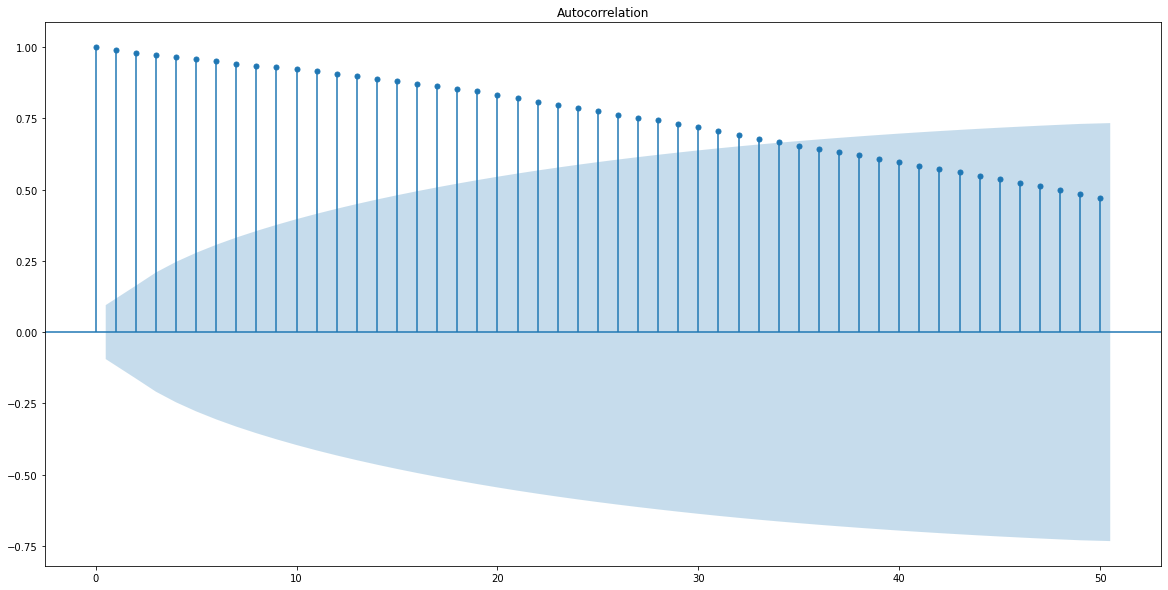

In [196]:
plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(spread["CBT_US-TU"].dropna(),lags=50 )
plt.show()

The above graph shows that there is some amount of autocorrelation. This implies that past spread values impact future values.

### Checking for stationarity in the spread using the adf test

In [205]:
def stationarity(a, cutoff = 0.05):
  a = np.ravel(a)
  if adfuller(a)[1] < cutoff:
    print('The series is stationary')
    print('p-value =', adfuller(a)[1])
  else:
    print('The series is NOT stationary')
    print('p-value = ', adfuller(a)[1])
stationarity(spread['CBT_US-TU'].dropna())
stationarity(spread['CBT_US-FV'].dropna())
# def cointegration(a, b):
#   if coint(a, b)[1] < 0.05:
#     print('The series are cointegrated')
#     print('p-value = ', coint(a, b)[1])
#   else:
#     print('The series are NOT cointegrated')
#     print('p-value = ', coint(a, b)[1])
# cointegration(spread['CBT_US-TU'].dropna(), spread['CBT_US-FV'].dropna())

The series is NOT stationary
p-value =  0.572526301985243
The series is NOT stationary
p-value =  0.6437515234409539


### Conclusion

We Find the two spreads have similar trends.

We looked at the spread statistics and also the tail statistics 

We found that the spread has autocorrelation

The stationarity test showed that the series is NOT Staionary 